In [4]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [8]:
model = keras.models.load_model('model.h5')

In [20]:
def prediction(image_path):
    img = load_img(image_path,target_size = (224,224))
    image = img_to_array(img)
    image = np.expand_dims(image,axis=0)
    preds = np.argmax(model.predict(image))
    
    plt.imshow(img)
    if preds == 0:
        plt.title("True")
    else :
        plt.title("False")

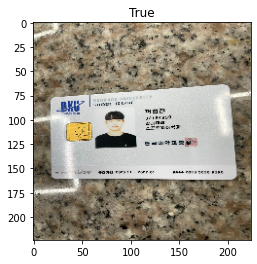

In [21]:
prediction('../home/examples/1.jpg')

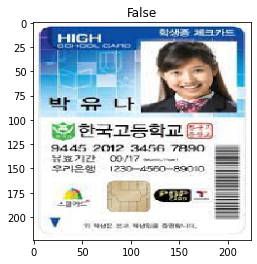

In [22]:
prediction('../home/examples/false.jpg')

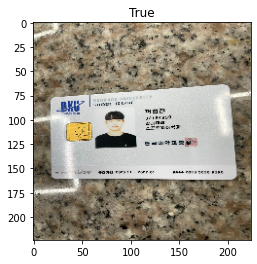

In [23]:
prediction('../home/examples/true.jpg')

In [28]:
import os
directory = '../home/augmentation/test/true/'
for file in os.listdir(directory):
    src = directory+file
    img = load_img(src,target_size = (224,224))
    image = img_to_array(img)
    image = np.expand_dims(image,axis=0)
    preds = np.argmax(model.predict(image))
    if preds == 0 :
        print("True")
    else :
        print("False")

False
True
True
False
True
True
False
True
False
False


In [29]:
import os
directory = '../home/augmentation/test/false/'
for file in os.listdir(directory):
    src = directory+file
    img = load_img(src,target_size = (224,224))
    image = img_to_array(img)
    image = np.expand_dims(image,axis=0)
    preds = np.argmax(model.predict(image))
    if preds == 0 :
        print("True")
    else :
        print("False")

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [1]:
from keras import layers
from keras import models
from keras import backend as K

import cv2

In [2]:
def gradCAM(image):
    conv_layer = model.get_layer("conv5_block3_3_conv")
    heatmap_model = models.Model([model.inputs],[conv_layer.output,model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(image) # y^c, c
        loss = predictions[:, np.argmax(predictions[0])] # probability
        grads = gtape.gradient(loss, conv_output) # partial-derivative
        pooled_grads = K.mean(grads, axis=(0, 1, 2)) # a_k^c , weight

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) # summation weight * filter
    heatmap = np.maximum(heatmap, 0) # ReLu
    max_heat = np.max(heatmap) # normalization    


    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    image = image[0]
    image = cv2.resize(image, (112,153))

    hm = heatmap[0]
    hm = cv2.resize(hm, (image.shape[1],image.shape[0]))
    hm = np.uint8(255*hm)
    hm = cv2.applyColorMap(hm,cv2.COLORMAP_JET)

    cvt_heatmap = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

    superimposed_img = cvt_heatmap * 0.9 + image

    superimposed_img[superimposed_img > 255] = 255
    superimposed_img = superimposed_img.astype('uint8')


    return superimposed_img

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator

datagen = ImageDataGenerator(
        brightness_range = [0.7,1.3], 
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images left and right
        vertical_flip=True)  # randomly flip images upside down

In [10]:
import tensorflow as tf

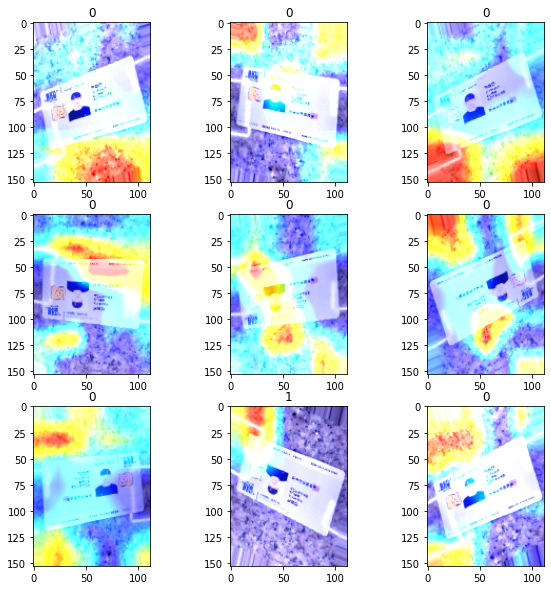

In [11]:
img_path = '../home/examples/1.jpg' # success

img = load_img(img_path, target_size = (224,224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)


it = datagen.flow(x, batch_size=32)
fig = plt.figure(figsize = (10,10))

# layer which calculate `score class`-

# 9개 이미지 생성
for i in range(9):
    plt.subplot(3, 3, i+1)
    batch = it.next()
    
    image = gradCAM(batch)
    plt.imshow(image)
    predict = np.argmax(model.predict(batch))
    plt.title(predict)

# show the figure
plt.show()